## Dosser North Climatology

In [1]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
single = xr.open_dataset('../../tracers/north/Dosser_north_TEOS10.nc')
single

<xarray.Dataset>
Dimensions:       (deptht: 40, time_counter: 12, xbT: 30, yb: 10)
Coordinates:
  * deptht        (deptht) float32 0.5 1.5 2.5 3.5 ... 360.7 387.6 414.5 441.5
  * time_counter  (time_counter) float32 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
Dimensions without coordinates: xbT, yb
Data variables:
    votemper      (time_counter, deptht, yb, xbT) float32 ...
    vosaline      (time_counter, deptht, yb, xbT) float32 ...
Attributes:
    Conventions:  CF-1.6
    title:        Temperature & Salinity Boundary Conditions for Northern Bou...
    institution:  Dept of Earth, Ocean & Atmospheric Sciences, University of ...
    source:       https://bitbucket.org/salishsea/tools/src/tip/I_ForcingFile...
    history:      [2018-07-14 14:42:33] Created netCDF4 zlib=True dataset.
    comment:      T & S data from Hayley Dosser monthly climatology, TEOS10
    references:   tracers/north/Dosser_north_TEOS10.nc

In [3]:
ozsize = single.deptht.shape[0]
zsize = 2*single.deptht.shape[0]
tsize = single.time_counter.shape[0]
xbTsize = 2*single.xbT.shape[0]
ybsize = 2*single.yb.shape[0] 

In [4]:
omesh = xr.open_dataset('../../grid/mesh_mask202108.nc')
odeptht = omesh.gdept_1d[0]

In [5]:
mesh = xr.open_dataset('../../grid/mesh_mask_double_202206.nc')
deptht = mesh.gdept_1d[0]

In [6]:
def duplicate_copy(single, tsize, zsize, ysize, xsize):
    double = np.zeros((tsize, zsize, ysize, xsize))
    double[:, 0::2, 0::2, 0::2] = single[:]
    double[:, 1::2, 0::2, 0::2] = single[:] 
    double[:, 0::2, 1::2, 0::2] = single[:]
    double[:, 1::2, 1::2, 0::2] = single[:] 
    double[:, 0::2, 0::2, 1::2] = single[:]
    double[:, 1::2, 0::2, 1::2] = single[:] 
    double[:, 0::2, 1::2, 1::2] = single[:]
    double[:, 1::2, 1::2, 1::2] = single[:] 
    return double

In [7]:
def duplicate_interpolate(single, tsize, zsize, ysize, xsize, ozsize, deptht, odeptht):
    double = np.zeros((tsize, zsize, ysize, xsize))
    io = 0
    for inew in range(zsize):
        while io < odeptht.shape[0]-1 and deptht[inew] > odeptht[io]:
            io = io + 1
        if deptht[inew] == odeptht[io]:
            double[:, inew, 0::2, 0::2] = single[:, io]
        else: 
            if io == 0:
                topi, boti = 0, 1
            else:
                topi, boti = io-1, io
            slope = (single[:, boti] - single[:, topi]) / (odeptht[boti] - odeptht[topi])
            intercept = single[:, boti] - slope * odeptht[boti]
            double[:, inew, 0::2, 0::2] = intercept + slope * deptht[inew]
    double[:, :, 1::2, 0::2] = double[:, :, 0::2, 0::2]
    double[:, :, 0::2, 1::2] = double[:, :, 0::2, 0::2]
    double[:, :, 1::2, 1::2] = double[:, :, 0::2, 0::2]
    return double

In [8]:
votemper = duplicate_interpolate(single.votemper, tsize, zsize, ybsize, xbTsize, ozsize, np.array(deptht), np.array(odeptht))

In [9]:
vosaline = duplicate_interpolate(single.vosaline, tsize, zsize, ybsize, xbTsize, ozsize, np.array(deptht), np.array(odeptht))

<ipython-input-10-9ec6d12f104e>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  colours = axs[1].pcolormesh(np.arange(12), -deptht, votemper[:, :, 5*2, 15*2].transpose())


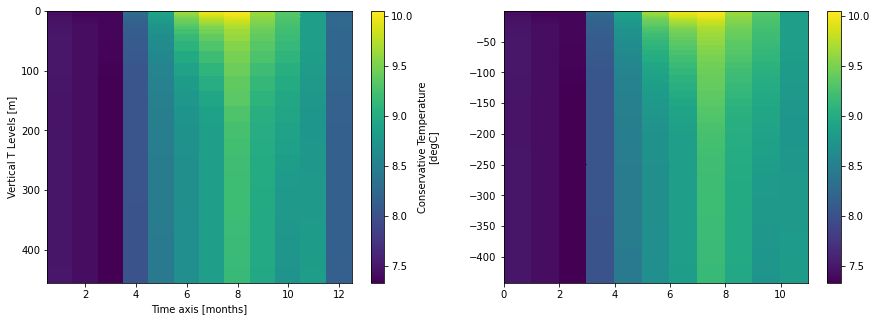

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
single.votemper[:, :, 5, 15].transpose().plot(ax=axs[0], yincrease=False)
colours = axs[1].pcolormesh(np.arange(12), -deptht, votemper[:, :, 5*2, 15*2].transpose())
fig.colorbar(colours, ax=axs[1])

<ipython-input-11-de91c60af9e5>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  colours = axs[1].pcolormesh(np.arange(12), -deptht, vosaline[:, :, 5*2, 15*2].transpose())


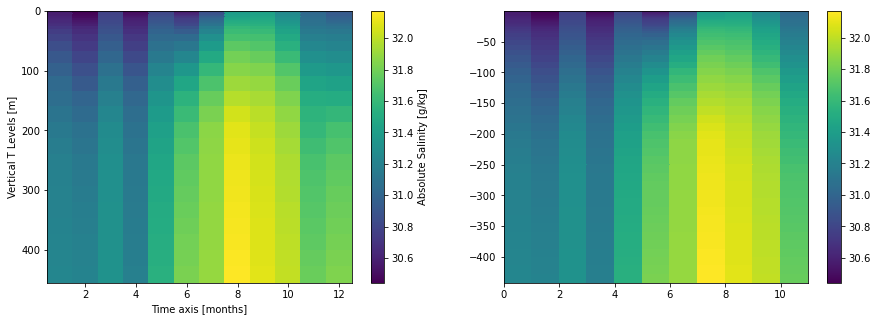

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
single.vosaline[:, :, 5, 15].transpose().plot(ax=axs[0], yincrease=False)
colours = axs[1].pcolormesh(np.arange(12), -deptht, vosaline[:, :, 5*2, 15*2].transpose())
fig.colorbar(colours, ax=axs[1])

In [12]:
filename = f'Dosser_north_double.nc'
# Add some global attributes
ds_attrs = {
'acknowledgements':
    'from Hailey Dosser, Hakai',
'creator_email':
    'sallen@eoas.ubc.ca',
'creator_name':
    'Salish Sea MEOPAR Project Contributors',
'creator_url':
    'https://salishsea-meopar-docs.readthedocs.org/',
'institution':
    'UBC EOAS',
'institution_fullname': (
    'Earth, Ocean & Atmospheric Sciences,'
    ' University of British Columbia'
),
'summary': (
    'T&S file, interpolated vertical and doubled horizontally from Dosser_north_TEOS10'
),
'source': (
    'tools/double_resolution/North_OBC.ipynb'
),
'history': (
    '[{}] File creation.'
    .format(datetime.datetime.today().strftime('%Y-%m-%d'))
)
}  

da = {}
interpl = {
    'votemper': votemper,
    'vosaline': vosaline
}
for var in interpl.keys():
    dims = ('time_counter','deptht', 'yb', 'xbT')
    coords = {'time_counter': single.time_counter, 
              'deptht': np.array(deptht),
              'yb': np.arange(ybsize), 
              'xbT': np.arange(xbTsize)}
    attrs = single[var].attrs

    da[var] = xr.DataArray(
        data=interpl[var],
        name=var,
        dims=dims,
        coords=coords,
        attrs=attrs
    )
ds = xr.Dataset(
data_vars=da,
coords=coords,
attrs=ds_attrs
)
encoding = {var: {'zlib': True} for var in ds.data_vars}
ds.to_netcdf(
path=filename,
unlimited_dims=('time_counter'),
encoding=encoding,
)

In [13]:
xr.open_dataset('Dosser_north_double.nc')

<xarray.Dataset>
Dimensions:       (deptht: 80, time_counter: 12, xbT: 60, yb: 20)
Coordinates:
  * time_counter  (time_counter) float32 1.0 2.0 3.0 4.0 ... 9.0 10.0 11.0 12.0
  * deptht        (deptht) float64 0.25 0.75 1.25 1.75 ... 414.5 428.2 441.8
  * yb            (yb) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * xbT           (xbT) int64 0 1 2 3 4 5 6 7 8 9 ... 51 52 53 54 55 56 57 58 59
Data variables:
    votemper      (time_counter, deptht, yb, xbT) float64 ...
    vosaline      (time_counter, deptht, yb, xbT) float64 ...
Attributes:
    acknowledgements:      from Hailey Dosser, Hakai
    creator_email:         sallen@eoas.ubc.ca
    creator_name:          Salish Sea MEOPAR Project Contributors
    creator_url:           https://salishsea-meopar-docs.readthedocs.org/
    institution:           UBC EOAS
    institution_fullname:  Earth, Ocean & Atmospheric Sciences, University of...
    summary:               T&S file, interpolated vertical and doubled horizo...
    source:                tools/double_resolution/North_OBC.ipynb
    history:               [2022-06-21] File creation.